In [39]:
%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 14})
# plt.rcParams['figure.figsize'] = (10,5)

## Вычисление производной
Ошибка в значении производной начинает возрастать, начиная с некоторого шага

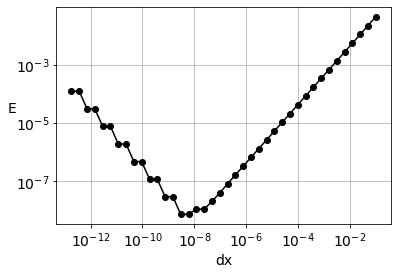

In [40]:
# Функция f
f =  lambda x: np.sin(x)
# Функция f'
df = lambda x: np.cos(x)
# Точка, в которой вычисляется приближенное значение
x0 = np.pi/3
# Сколько раз начальный шаг уменьшается вдвое
n = 40
# Самый большой шаг
dx0 = 1e-1
# Массив шагов
dx = dx0 / 2.0**np.arange(n)
# Массив приближенных значений производной
df_appr = (f(x0 + dx) - f(x0)) / dx

plt.loglog(dx, np.abs(df_appr - df(x0)), 'ko-')
plt.xlabel('dx')
plt.ylabel('E', rotation = 0)
plt.grid('On')

## Плохая матрица
При решении с некоторыми матрицами могут возникать большие погрешности

In [41]:
# Размер линейной системы
n = 50
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        A[i,j] = 1 / (i + j  + 1)
# Точное решение
x = np.ones(n)
# Правая часть, соответствующая точному решению
b = A @ x
y = np.linalg.solve(A, b)
print('Относительная Ошибка: = {0:6.3e}'.
      format(np.max(np.abs(y - x)) /np.max(np.abs(x))))

Относительная Ошибка: = 5.472e+01


Для случайной матрицы ошибка мала:

In [42]:
# Размер линейной системы
n = 50
A = np.zeros((n,n))
A = np.random.rand(n, n)
# Точное решение
x = np.ones(n)
# Правая часть, соответствующая точному решению
b = A @ x
y = np.linalg.solve(A, b)
print('Относительная Ошибка: = {0:6.3e}'.
      format(np.max(np.abs(y - x)) /np.max(np.abs(x))))

Относительная Ошибка: = 1.221e-14


##  Интерполяция
С помощью готовых функций находим единственный многочлен, проходящий через заданные точки.

Одна из функций выдаёт многочлен, который не проходит через точки.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


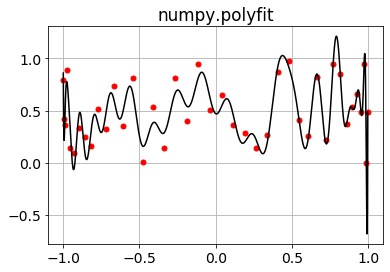

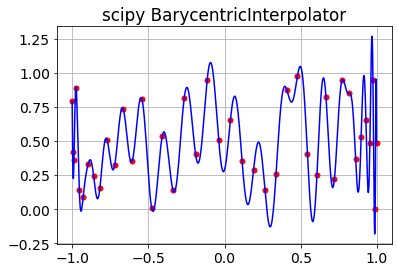

In [49]:
from scipy.interpolate import BarycentricInterpolator
# Количество точек
n = 40
# Задаём точки (неравномерная сетка для удобства)
x = np.cos(np.pi * np.linspace(-1,0., n+1, endpoint=False))
x = np.sort(x)
# Задаём случайные значения в точках
y = np.random.rand(n+1)
# p - массив коэффициентов многочлена
p = np.polyfit(x, y, n)
xx = np.linspace(np.min(x),np.max(x),1000)
# Вычисляем значения многочлена на подробной сетке и строим график
yy = np.polyval(p, xx)
plt.plot(x,y,'ro', ms = 5)
plt.plot(xx, yy,'k-')
plt.title('numpy.polyfit')
plt.grid(True)
plt.show()
#
L = BarycentricInterpolator(x,y)
plt.plot(x,y,'ro', ms = 5)
plt.plot(xx, L(xx), 'b-')
plt.title('scipy BarycentricInterpolator')
plt.grid(True)

## Расходимость интерполяционного процесса
Выбрав лучшую из двух функций строим графики интерполяцинных многочленов на равномерной и неравномерной сетках. 

Многочлены, построенные по равномерной сетке, не сходятся к исходной функции.

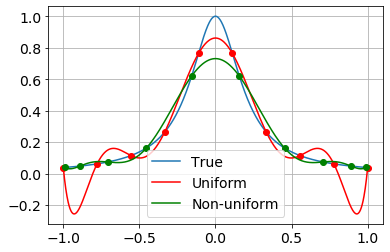

In [44]:
# Специальная функция
f = lambda x: 1 / (1 + 25 * x**2)

xx = np.linspace(-1, 1, 1000)
plt.plot(xx, f(xx), label = 'True')

# Число узлов
n = 10
x_uni  = np.linspace(-1, 1, n)
y_uni  = f(x_uni)

x_cheb = np.cos(np.pi * (2 * np.arange(n) + 1) / (2 * n) )
x_cheb = np.sort(x_cheb)
y_cheb = f(x_cheb)

L_uni = BarycentricInterpolator(x_uni, y_uni)

L_cheb = BarycentricInterpolator(x_cheb, y_cheb)

plt.plot(xx, L_uni(xx), 'r-', label = 'Uniform')
plt.plot(x_uni, y_uni, 'ro')

plt.plot(xx, L_cheb(xx), 'g-', label = 'Non-uniform')
plt.plot(x_cheb, L_cheb(x_cheb), 'go')
plt.grid(True)
plt.legend()

## Решение уравнения Лапласа
Функция для решение уравнения $\Delta u(x,y) = 0$ конечно-разностным методом. 

Линейная система решается итерационным методом Якоби. 

Пример интересен тем, что на конечную ошибку влияет и шаг дискретной сетки и точность решения линейной системы.
Постановка взята из [https://faculty.washington.edu/rjl/classes/am583s2014/notes/index.html]

In [45]:
def solve_laplace(N, T1, T2, tol = 1e-3, max_it = 1e+4):
    """
    T1, T2 - температуры горячей и холодной частей границы
    tol - критерий остановки для метода Якоби
    """
    h = 1 / N # шаг сетки
    u = np.zeros((N+1, N+1)) # массив для решения
    u_new = np.zeros((N+1, N+1)) # решение на следующей итерации
    x = np.arange(N+1) * h # x = i * h, i = 0,...,N
    y = np.arange(N+1) * h # y = j * h, j = 0,...,N
    # Задаём граничные условия
    u_new[:, 0] = T1 
    u_new[0, :] = T1
    u_new[:, N] = np.where(np.logical_or(x<0.4, x>0.6), T1, T2)         
    u_new[N, :] = np.where(np.logical_or(y<0.2, y>0.8), T1, T2) 
    it = 0
    while True:
        it = it + 1
        u = np.copy(u_new)
        for i in range(1, N):
            for j in range(1, N):
                u_new[i, j] = 0.25 *(u[i+1, j] + u[i-1, j] + u[i, j-1] + u[i, j+1])
        delta = np.max(np.abs(u_new - u)) / np.max(np.abs(u_new))
        if ((delta < tol) or (it > max_it)):
            break
    return u_new.T, x, y, it, delta

Запускаем расчёт для конкретных параметров

it = 2651, delta = 9.96e-07, u(0.5, 0.5) = 358.54


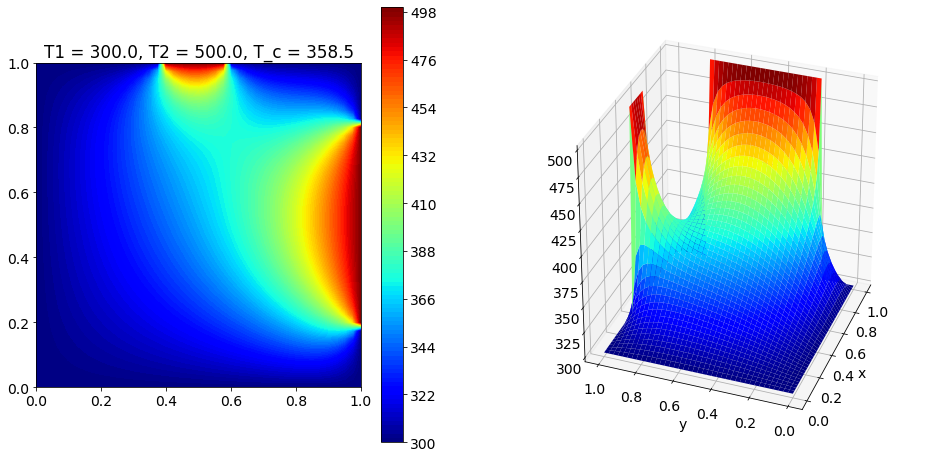

In [46]:
T1 = 300
T2 = 500
u, x, y, it, delta = solve_laplace(N = 40, T1 = T1, T2 = T2, tol = 1e-6, max_it=1e+4)
T_c = u[u.shape[0]//2, u.shape[0]//2]
print('it = {0:d}, delta = {1:5.2e}, u(0.5, 0.5) = {2:5.2f}'.format(it, delta, T_c))
#
# Draw figures
#
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1, 2, 1)
cf = ax1.contourf(X, Y, u, 100, cmap = 'jet')
ax1.set_title('T1 = {0:5.1f}, T2 = {1:5.1f}, T_c = {2:5.1f}'.format(T1,T2,T_c))
fig.colorbar(cf, ax=ax1)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.view_init(30, 200)
surf = ax2.plot_surface(X, Y, u, 
                        cmap ='jet', lw=0, antialiased=True)

## Машинная арифметика

Машинное эпсилон

In [47]:
##
a = np.float32(1.0)
b = np.float32(2**(-23))
c = np.float32()
c = a + b
print(c)

a = np.float32(1.0)
b = np.float32(2**(-24))
c = np.float32()
c = a + b
print(c)

1.0000001
1.0


In [48]:
a = np.float64(1.0)
b = np.float64(2**(-52))
c = np.float64()
c = a + b
print(c)

a = np.float64(1.0)
b = np.float64(2**(-53))
c = np.float64()
c = a + b
print(c)


1.0000000000000002
1.0
